## Code Flow

1. Load and clean daily adjusted close data for all available NYSE stocks in eodhistoricaldata.com
2. Load sector data (GICS sector for each stock in the universe)
3. Generate unique (non-reversed, i.e. AAPL/MSFT and MSFT/AAPL) pairs universe for a given sector (we will use Financials)
4. Split timeframe into IN-OOS for Walk-forward analysis
5. Run in-sample backtests using the z-score of the distance, and static entry and exit thresholds (2.5, 1 -> aiming for 1.5 deviation move as profit target)
6. Run various pair selection methods from in-sample data (of each batch)
7. Get average stats across OOS batches, for each selection method
8. Summarize results

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import empyrical as ep
import pandas as pd
import yfinance as yf
from tqdm import tqdm
import vectorbt as vbt

### Load price and sector data

In [300]:
raw_prices = pd.read_csv('price_data.csv')
raw_prices = raw_prices.ffill().dropna(axis=1)
raw_prices.date = pd.to_datetime(raw_prices.date)
raw_prices.set_index('date', inplace=True)
raw_prices.drop(columns=['CIR', 'EMAN'], inplace=True) # price equals zero at few dates
universe = raw_prices.columns

fundamentals = pd.read_csv('sector_data.csv')
fundamentals.columns = ['asset', 'GicSector']
fundamentals = fundamentals.set_index('asset').loc[universe].reset_index()
fundamentals.columns = ['asset', 'GicSector']
sectors = fundamentals.GicSector.dropna().unique().tolist()

raw_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3502 entries, 2010-01-04 to 2023-11-10
Columns: 1376 entries, A to ZBH
dtypes: float64(1376)
memory usage: 36.8 MB


### Create pairs universe

In [5]:
pairs = []
for sector in tqdm(sectors):
    # sector = 'Consumer Staples'
    u = fundamentals[fundamentals.GicSector == 'Financials'].asset.tolist()
    for s1 in u:
        for s2 in u:
            if s1 != s2: pairs.append(f'{s1}/{s2}')

# Drop inverse pairs
seen_pairs = set()
unique_pairs = []
for pair in pairs:
    # sort the pair to create a unique identifier for the pair
    sorted_pair = tuple(sorted(pair))
    # if the pair is already in the set, skip it
    if sorted_pair in seen_pairs:
        continue
    # add the sorted pair to the set and the unique pairs list
    seen_pairs.add(sorted_pair)
    unique_pairs.append(pair)    
pairs = unique_pairs

len(pairs)

100%|█████████████████████████████████████████████| 11/11 [00:00<00:00, 133.64it/s]


14806

### Split into in-sample and out-of-sample batches

In [141]:
split_kwargs = dict(
    n=10, 
    window_len=365 * 2, 
    set_lens=(305,), 
    left_to_right=False
)  # 10 windows, each ~3 years long, 305 days for OOS (305 in order to match the end of the current with the start of the next batch, thus allowing for a continuous portfolio analysis 

def roll_in_and_out_samples(price, **kwargs):
    return price.vbt.rolling_split(**kwargs)

roll_in_and_out_samples(raw_prices[raw_prices.columns[0]], **split_kwargs, plot=True, trace_names=['in-sample', 'out-sample'])

D:\vkotopoulos\resume_portfolio\pairs\env\lib\site-packages\jupyter_client\session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

D:\vkotopoulos\resume_portfolio\pairs\env\lib\site-packages\jupyter_client\session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



FigureWidget({
    'data': [{'colorscale': [[0.0, '#1f77b4'], [1.0, '#1f77b4']],
              'hoverongaps': False,
              'name': 'in-sample',
              'showlegend': True,
              'showscale': False,
              'type': 'heatmap',
              'uid': 'a6abc3f6-1ef5-4064-9d1e-0ca0a6614ba3',
              'x': array([datetime.datetime(2010, 1, 4, 0, 0),
                          datetime.datetime(2010, 1, 5, 0, 0),
                          datetime.datetime(2010, 1, 6, 0, 0), ...,
                          datetime.datetime(2023, 11, 8, 0, 0),
                          datetime.datetime(2023, 11, 9, 0, 0),
                          datetime.datetime(2023, 11, 10, 0, 0)], dtype=object),
              'y': array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0], dtype=int64),
              'z': array([[nan, nan, nan, ..., nan, nan, nan],
                          [nan, nan, nan, ..., nan, nan, nan],
                          [nan, nan, nan, ..., nan, nan, nan],
                       

In [106]:
(in_price, in_indexes), (out_price, out_indexes) = roll_in_and_out_samples(raw_prices, **split_kwargs)

print(in_price.shape, len(in_indexes))  # in-sample
print(out_price.shape, len(out_indexes))  # out-sample


(425, 7660) 10
(305, 7660) 10


### Get in-sample stats for each batch, for each pair


In [6]:
# Define trading parameters

entry = 2.7
exit_stretch = 1
window = 100

In [67]:
# Construct zscores

def roll_zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

zscores = {}
window = 100
for pair in tqdm(pairs):
    s1 = pair.split('/')[0]
    s2 = pair.split('/')[1]
    r = abs(raw_prices[s1] - raw_prices[s2])
    z = roll_zscore(r, window)
    z.name = pair
    zscores[pair] = z

zscores = pd.DataFrame(zscores)

100%|███████████████████████████████████████| 14806/14806 [00:18<00:00, 786.68it/s]


In [131]:
def get_adfuller(s):
    try:
        adf = adfuller(s.dropna())
        if adf[0] < adf[4]['1%']:
            return adf[1]
        else:
            return np.nan
    except:
        return np.nan

in_sample_stats = pd.DataFrame()

for i, batch in enumerate(in_indexes):

    # Run backtest per pair 
    
    pairs_stats = {}
    
    for pair in tqdm(pairs):
    
        # Get Entry and Exit signals
        
        longs = zscores[pair].loc[batch] < -entry
        shorts = zscores[pair].loc[batch] > entry
        long_exits = zscores[pair].loc[batch] > -exit_stretch 
        short_exits = zscores[pair].loc[batch] < exit_stretch
        
        # Backtest first leg 
    
        longs.columns = pair.split('/')[0]
        shorts.columns = pair.split('/')[0]
        long_exits.columns = pair.split('/')[0]
        short_exits.columns = pair.split('/')[0]
        
        pf1 = vbt.Portfolio.from_signals(
            raw_prices[pair.split('/')[0]].loc[longs.index],
            entries=longs,
            short_entries=shorts,
            exits=long_exits,
            short_exits=short_exits
            )
        pf1_trades = pf1.trades.records_readable
        pf1_trades['asset'] = pair.split('/')[0]
        
        # Backtest second leg
        
        longs.columns = pair.split('/')[1]
        shorts.columns = pair.split('/')[1]
        long_exits.columns = pair.split('/')[1]
        short_exits.columns = pair.split('/')[1]
        
        pf2 = vbt.Portfolio.from_signals(
            raw_prices[pair.split('/')[1]].loc[longs.index],
            entries=shorts,
            short_entries=longs,
            exits=short_exits,
            short_exits=long_exits
            )
        pf2_trades = pf2.trades.records_readable
        pf2_trades['asset'] = pair.split('/')[1]
        
        # Merge data
        
        mean_data = (pf1.returns().to_numpy() + pf2.returns().to_numpy())/2
        pair_rets = pd.DataFrame(mean_data, columns=[pair], index=pf1.returns().index)
        pair_trades = pd.concat([pf1_trades, pf2_trades])

        # Compute pair stats
        
        avg_trade = pair_trades[['Return', 'Exit Timestamp']].groupby('Exit Timestamp').mean().Return.mean()
        n_trades = len(pf1_trades)
        sr = ep.sharpe_ratio(pair_rets[pair])
        maxdd = ep.max_drawdown(pair_rets[pair])
        corr = raw_prices[pair.split('/')[0]].loc[batch].corr(raw_prices[pair.split('/')[1]].loc[batch])
        adf = get_adfuller(zscores[pair].loc[batch].dropna())
        
        pairs_stats[pair] = [avg_trade, n_trades, sr, maxdd, corr, adf]    

    # Store in-sample batch stats 
    
    t = pd.DataFrame(pairs_stats).T.reset_index()
    t.columns = ['pair', 'avg_trade', 'n_trades', 'sr', 'maxdd', 'corr', 'adf']
    t['batch'] = i
    in_sample_stats = pd.concat([in_sample_stats, t])

  1%|▎                                          | 96/14806 [00:08<21:35, 11.35it/s]D:\vkotopoulos\resume_portfolio\pairs\env\lib\site-packages\empyrical\stats.py:293: RuntimeWarning:

invalid value encountered in subtract

D:\vkotopoulos\resume_portfolio\pairs\env\lib\site-packages\empyrical\stats.py:293: RuntimeWarning:

invalid value encountered in divide

 84%|█████████████████████████████████▌      | 12406/14806 [18:36<03:34, 11.21it/s]D:\vkotopoulos\resume_portfolio\pairs\env\lib\site-packages\empyrical\stats.py:293: RuntimeWarning:

invalid value encountered in subtract

100%|████████████████████████████████████████| 14806/14806 [22:09<00:00, 11.14it/s]


In [132]:
in_sample_stats.to_csv('in_sample_stats.csv', index=False)

### Get Top Performers per batch

In [278]:
in_sample_tops = {}
for i in in_sample_stats.batch.unique():

    # Get top performers
    
    top = in_sample_stats[(in_sample_stats.batch==i) & \
                          (in_sample_stats.maxdd > -0.05) & \
                          (in_sample_stats['adf'] < 0.05) & \
                          (in_sample_stats.n_trades > 5)].sort_values('sr', ascending=False)

    # Get unique pairs (non-overlapping constituents)

    seen_assets = set()
    unique_pairs = []
    for s1, s2 in [x.split('/') for x in top.pair]:
        # if any of the assets is already in the set, skip it
        if (s1 in seen_assets) | (s2 in seen_assets):
            continue
        # add the pair to the set and the unique pairs list
        seen_assets.add(s1)
        seen_assets.add(s2)
        unique_pairs.append(s1+'/'+s2) 
        
    in_sample_tops[i] = top[top.pair.isin(unique_pairs)].head(10).pair.tolist()

### Compute stats for top performers in OOS

In [279]:
# Compute out of sample stats

out_sample_stats = pd.DataFrame()

for i, batch in tqdm(enumerate(out_indexes)):

    # Run backtest per pair 
    
    pairs_stats = {}
    
    for pair in in_sample_tops[i]:
    
        # Get Entry and Exit signals
        
        longs = zscores[pair].loc[batch] < -entry
        shorts = zscores[pair].loc[batch] > entry
        long_exits = zscores[pair].loc[batch] > -exit_stretch 
        short_exits = zscores[pair].loc[batch] < exit_stretch
        
        # Backtest first leg 
    
        longs.columns = pair.split('/')[0]
        shorts.columns = pair.split('/')[0]
        long_exits.columns = pair.split('/')[0]
        short_exits.columns = pair.split('/')[0]
        
        pf1 = vbt.Portfolio.from_signals(
            raw_prices[pair.split('/')[0]].loc[longs.index],
            entries=longs,
            short_entries=shorts,
            exits=long_exits,
            short_exits=short_exits
            )
        pf1_trades = pf1.trades.records_readable
        pf1_trades['asset'] = pair.split('/')[0]
        
        # Backtest second leg
        
        longs.columns = pair.split('/')[1]
        shorts.columns = pair.split('/')[1]
        long_exits.columns = pair.split('/')[1]
        short_exits.columns = pair.split('/')[1]
        
        pf2 = vbt.Portfolio.from_signals(
            raw_prices[pair.split('/')[1]].loc[longs.index],
            entries=shorts,
            short_entries=longs,
            exits=short_exits,
            short_exits=long_exits
            )
        pf2_trades = pf2.trades.records_readable
        pf2_trades['asset'] = pair.split('/')[1]
        
        # Merge data
        
        mean_data = (pf1.returns().to_numpy() + pf2.returns().to_numpy())/2
        pair_rets = pd.DataFrame(mean_data, columns=[pair], index=pf1.returns().index)
        pair_trades = pd.concat([pf1_trades, pf2_trades])

        # Compute pair stats
        
        avg_trade = pair_trades[['Return', 'Exit Timestamp']].groupby('Exit Timestamp').mean().Return.mean()
        n_trades = len(pf1_trades)
        sr = ep.sharpe_ratio(pair_rets[pair])
        maxdd = ep.max_drawdown(pair_rets[pair])
        corr = raw_prices[pair.split('/')[0]].loc[batch].corr(raw_prices[pair.split('/')[1]].loc[batch])
        adf = get_adfuller(zscores[pair].loc[batch].dropna())
        coin = get_coint(raw_prices[pair.split('/')[0]].loc[batch], raw_prices[pair.split('/')[1]].loc[batch])
        total_ret = ep.cum_returns_final(pair_rets[pair])
        
        pairs_stats[pair] = [avg_trade, n_trades, sr, maxdd, corr, adf, coin, total_ret]    

    # Store in-sample batch stats 
    
    t = pd.DataFrame(pairs_stats).T.reset_index()
    t.columns = ['pair', 'avg_trade', 'n_trades', 'sr', 'maxdd', 'corr', 'adf', 'coin', 'total_ret']
    t['batch'] = i
    out_sample_stats = pd.concat([out_sample_stats, t])

10it [00:08,  1.22it/s]


In [280]:
# m1 = out_sample_stats.copy()
# m2 = out_sample_stats.copy()
# m3 = out_sample_stats.copy()
m4 = out_sample_stats.copy()
# m5 = out_sample_stats.copy()


### Summarize Results

In [287]:
avgs_table = pd.DataFrame()

t = m1.drop(columns=['pair']).groupby('batch').mean().mean().to_frame().T.drop(columns='coin')
t.index = ['m1']
avgs_table = pd.concat([avgs_table, t])

t = m2.drop(columns=['pair']).groupby('batch').mean().mean().to_frame().T.drop(columns='coin')
t.index = ['m2']
avgs_table = pd.concat([avgs_table, t])

t = m3.drop(columns=['pair']).groupby('batch').mean().mean().to_frame().T.drop(columns='coin')
t.index = ['m3']
avgs_table = pd.concat([avgs_table, t])

t = m4.drop(columns=['pair']).groupby('batch').mean().mean().to_frame().T.drop(columns='coin')
t.index = ['m4']
avgs_table = pd.concat([avgs_table, t])

t = m5.drop(columns=['pair']).groupby('batch').mean().mean().to_frame().T.drop(columns='coin')
t.index = ['m5']
avgs_table = pd.concat([avgs_table, t])

avgs_table.round(4)

,avg_trade,n_trades,sr,maxdd,corr,adf,total_ret
m1,0.0111,2.9400,0.6783,-0.0468,0.5385,0.0020,0.0400
m2,0.0031,2.5100,0.3954,-0.0799,0.3780,0.0025,0.0188
m3,0.0105,2.7900,0.6583,-0.0406,0.6010,0.0026,0.0317
m4,0.0076,2.8586,0.6518,-0.0410,0.6149,0.0019,0.0287
m5,0.0074,2.8337,0.6199,-0.0395,0.6075,0.0024,0.0273


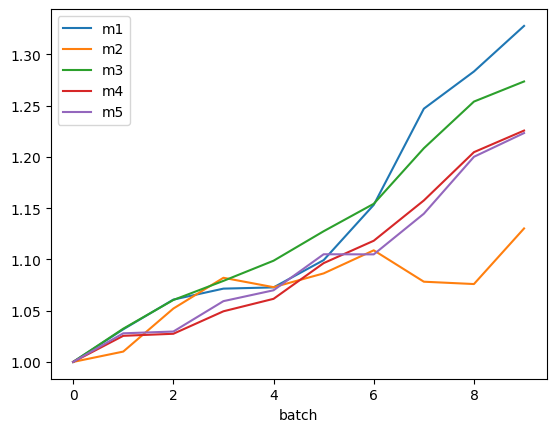

In [289]:
c1 = m1.drop(columns=['pair']).groupby('batch').mean().total_ret.cumsum() + 1
c2 = m2.drop(columns=['pair']).groupby('batch').mean().total_ret.cumsum() + 1
c3 = m3.drop(columns=['pair']).groupby('batch').mean().total_ret.cumsum() + 1
c4 = m4.drop(columns=['pair']).groupby('batch').mean().total_ret.cumsum() + 1
c5 = m5.drop(columns=['pair']).groupby('batch').mean().total_ret.cumsum() + 1


c1.div(c1.iloc[0]).plot(label='m1')
c2.div(c2.iloc[0]).plot(label='m2')
c3.div(c3.iloc[0]).plot(label='m3')
c4.div(c4.iloc[0]).plot(label='m4')
c5.div(c5.iloc[0]).plot(label='m5')


plt.legend()